In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load processed dataset

In [2]:
# Load data
df = pd.read_csv('./preprocessed_data.csv')

# Train-test split
X = df.drop(['Default'], axis=1)
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42 
)

# Train and evaluate models

## Decision Tree

### Before Hyperparameter tuning

In [18]:
#Plotting the Decision Tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42 
)

#Train the Decision Tree Classifier
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20, min_samples_leaf=2)

classifier.fit(X_train, y_train)  # Train the model
y_pred = classifier.predict(X_test)  # Make predictions

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     67709
           1       0.45      0.06      0.11      8896

    accuracy                           0.88     76605
   macro avg       0.67      0.53      0.52     76605
weighted avg       0.84      0.88      0.84     76605



ROC AUC Score: 0.7072385488720191


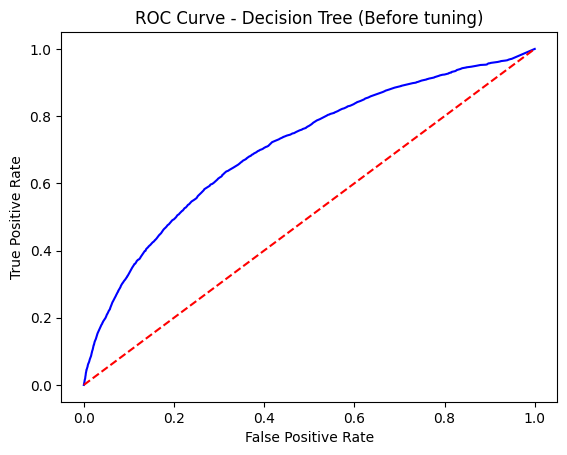

In [63]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_dt = classifier.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_dt)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Before tuning)');

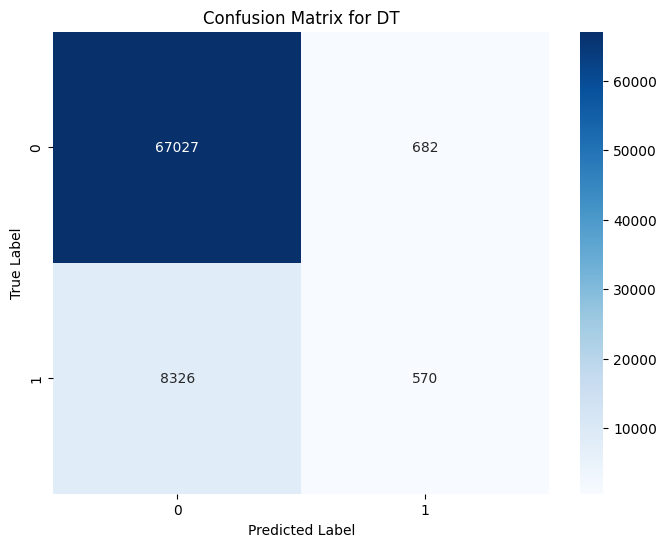

In [81]:
cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for DT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Display Decision Tree

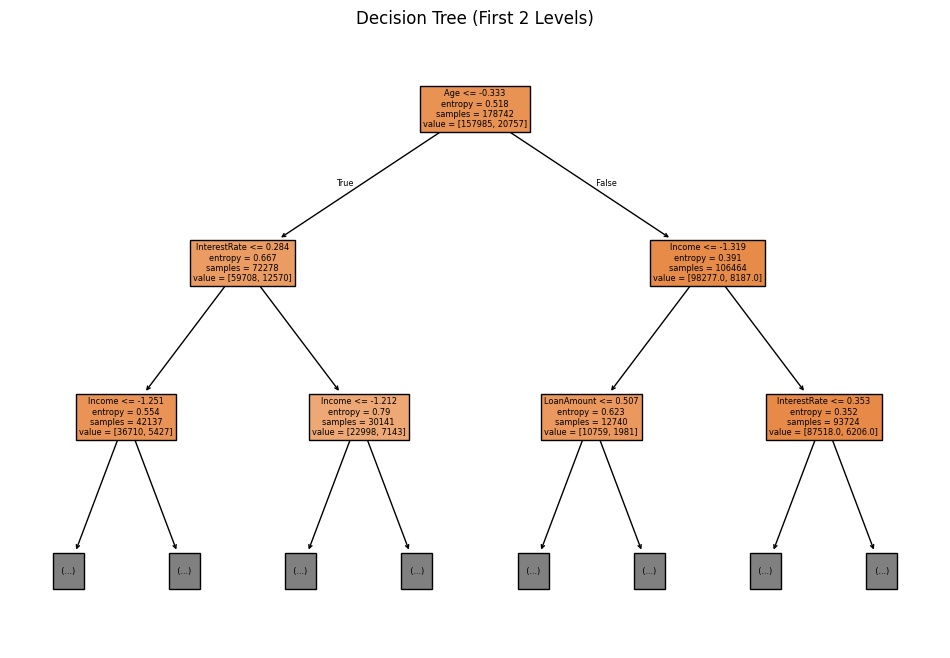

In [82]:
plt.figure(figsize=(12, 8))
plot_tree(classifier, filled=True, feature_names=X.columns, max_depth=2)
plt.title("Decision Tree (First 2 Levels)")
plt.show()

### With Hyperparameter Tuning

#### With Grid Search

In [32]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Define the model
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Set the parameter distribution
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 5, 10, 20],
}

# Define the cross-validation (cv) strategy
cv_dt = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with cross-validation
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=dt_param_grid,
    scoring='f1',  # Use F1 scoring to account for imbalanced dataset
    cv=cv_dt,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the grid search
grid_search_dt.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search_dt.best_params_)
print('Best cross-validation score using F1:', grid_search_dt.best_score_)

# Evaluate the best model on the test data
best_dt = grid_search_dt.best_estimator_
y_pred = best_dt.predict(X_test)

# Print evaluation metrics
print("F1:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Hyperparameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score using F1: 0.20997276191602596
F1: 0.21024924795874517
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89     67709
           1       0.20      0.22      0.21      8896

    accuracy                           0.81     76605
   macro avg       0.55      0.55      0.55     76605
weighted avg       0.82      0.81      0.81     76605



ROC AUC Score: 0.5526670506075461


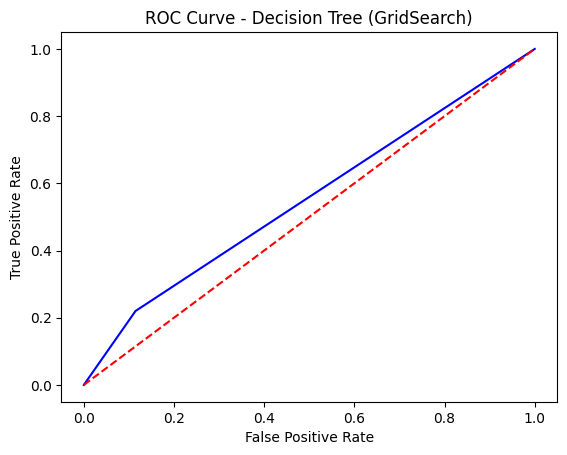

In [33]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_dt = best_dt.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_dt)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (GridSearch)');

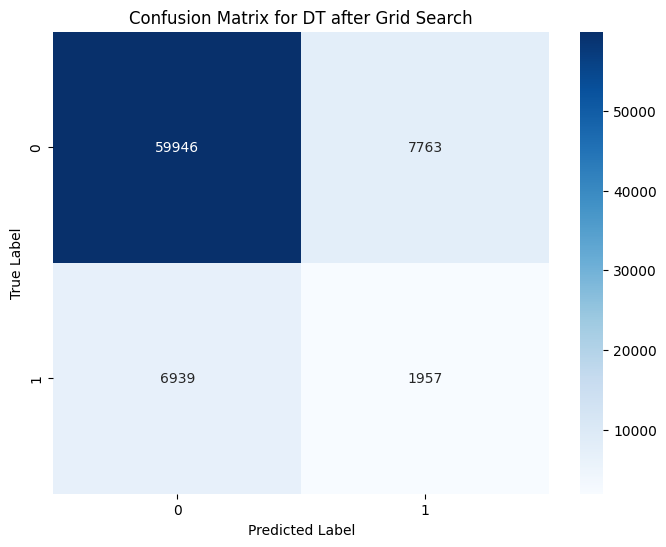

In [34]:
cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for DT after Grid Search')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### With Random Search

In [35]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Define the model
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Set the parameter distributions
dt_param_dist = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 5, 10, 20],
}

# Define the cross-validation (cv) strategy
cv_dt = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform RandomizedSearchCV with cross-validation
random_search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_dist,
    n_iter=50,  # Number of parameter combinations to try
    scoring='f1',  # Use F1 scoring to account for imbalanced dataset
    cv=cv_dt,
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the random search
random_search_dt.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search_dt.best_params_)
print('Best cross-validation score using F1:', random_search_dt.best_score_)

# Evaluate the best model on the test data
best_dt = random_search_dt.best_estimator_
y_pred = best_dt.predict(X_test)

# Print evaluation metrics
print("F1:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_depth': None}
Best cross-validation score using F1: 0.20604910848856955
F1: 0.21095113438045376
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89     67709
           1       0.20      0.22      0.21      8896

    accuracy                           0.81     76605
   macro avg       0.55      0.55      0.55     76605
weighted avg       0.82      0.81      0.81     76605



ROC AUC Score: 0.5610534032860258


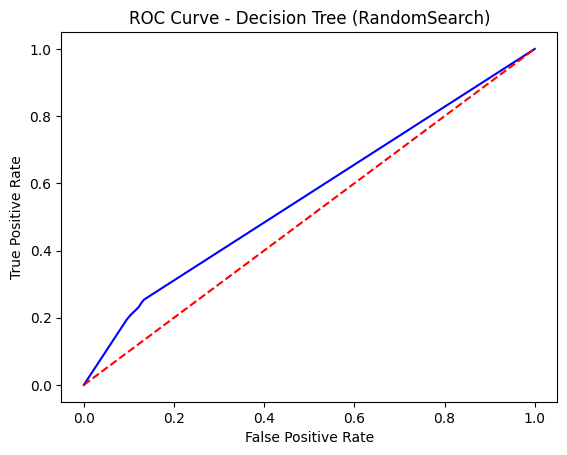

In [36]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_dt = best_dt.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_dt)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (RandomSearch)');

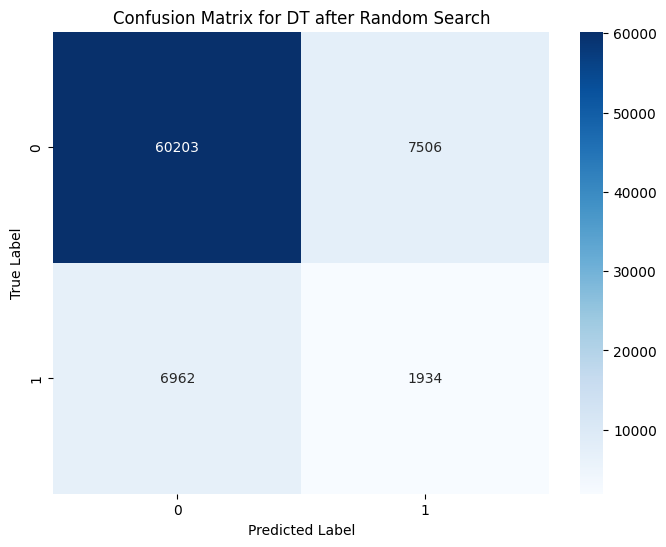

In [37]:
cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for DT after Random Search')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### With Halving Random Search

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Define the model
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Define the parameter grid for hyperparameter tuning
param_dist = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 5, 10, 20],
}

# Cross-validation strategy
cv_dt = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

random_search = HalvingRandomSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    scoring='f1',
    cv=cv_dt,
    factor=2,  # Reduce configurations by a factor of 2 at each iteration
    random_state=42,
    n_jobs=-1,
)

# Fit the random search
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
print("Best cross-validation score using F1:", random_search.best_score_)

# Evaluate the best model on the test data
best_dt = random_search.best_estimator_
y_pred = best_dt.predict(X_test)

# Print evaluation metrics
print("F1:", f1_score(y_test, y_pred))
print("Classification Report for dt after tuning:\n", classification_report(y_test, y_pred))

c:\Users\jenif\anaconda3\envs\new_env\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 192 is smaller than n_iter=8937. Running 192 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\jenif\anaconda3\envs\new_env\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_depth': 5}
Best cross-validation score using F1: 0.0700248893486436
F1: 0.04385107999565831
Classification Report for dt after tuning:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     67709
           1       0.64      0.02      0.04      8896

    accuracy                           0.89     76605
   macro avg       0.76      0.51      0.49     76605
weighted avg       0.86      0.89      0.83     76605



ROC AUC Score: 0.7206343350713394


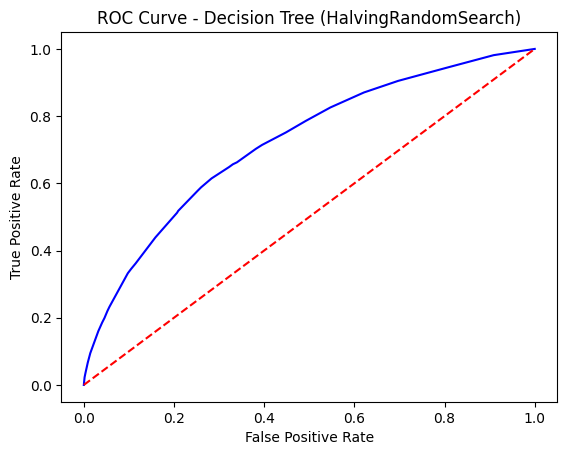

In [51]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_dt = best_dt.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_dt)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (HalvingRandomSearch)');

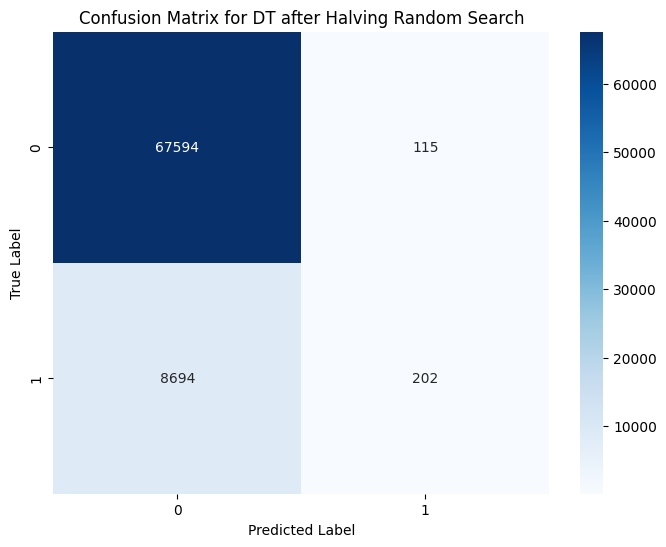

In [26]:
cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for DT after Halving Random Search')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Comparison of Results for Decision Trees
<b>DT before tuning</b>
<br>

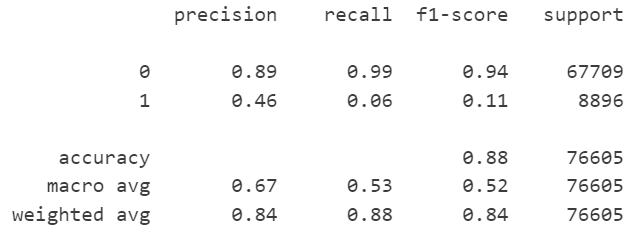

<b>DT after hyperparameter tuning with training data using Grid Search</b>
<br>

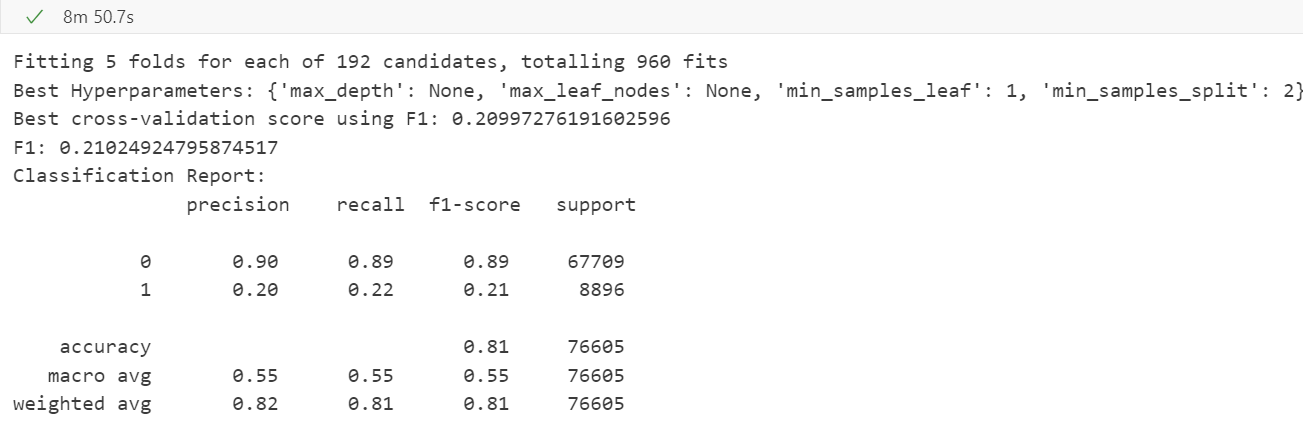

<b>DT after hyperparameter tuning with training data using Random Search</b>
<br>

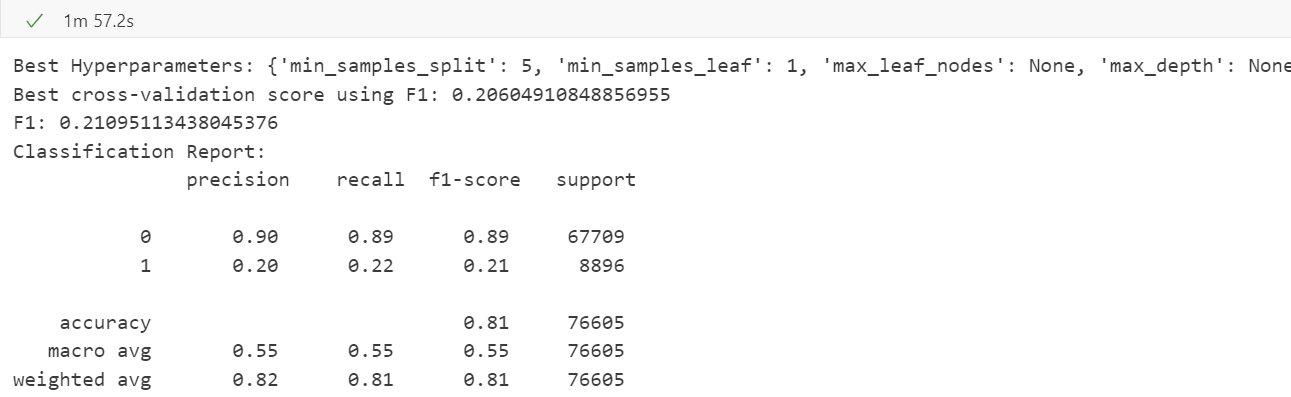
<br>
Both of the results are identical. Compared to the model without tuning, for the positive class, recall increased (+0.16) with more true positives (about +1400 from 570), but at the cost of precision (-0.26) due to more false positives (about +7000 from 682). The f1-score for the minority class increased overall (+0.10). There was a small cost in accuracy (-0.07) due to more misclassifications of the majority class. This is also reflected in the decreased recall (-0.10) for class 0.

<b>DT after hyperparameter tuning with training data using Halving Random Search</b>
<br>

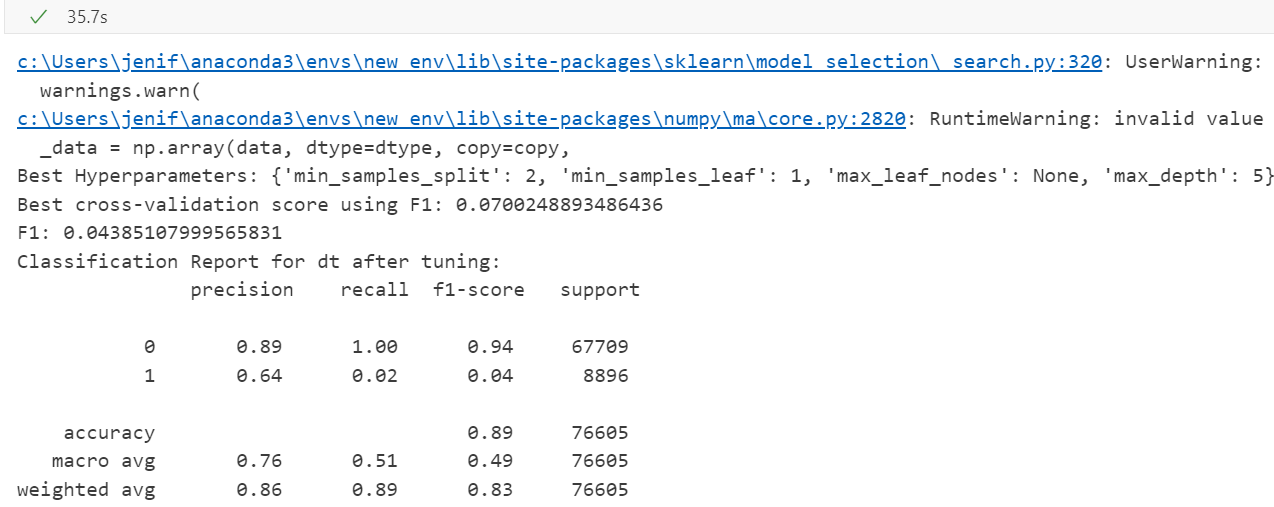

Using the halving random search method gives much worse results for DTs, unlike with the other models below (kNN and logistic regression). The recall and f-1 score for the positive class actually decreased (by -0.04 and -0.07 respectively) compared to the DT model without tuning. but the precision increased due to less false positives (-567 from 682).

#### Confusion Matrices Comparison for DT
<b>Before tuning</b>

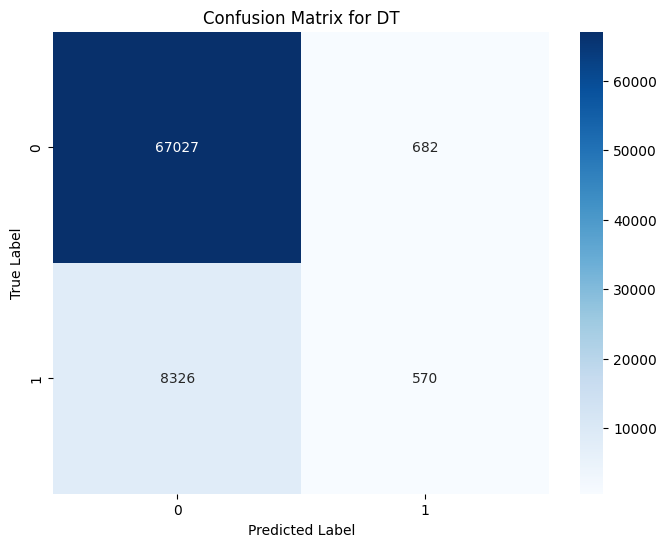
<br>
<b>After tuning</b>

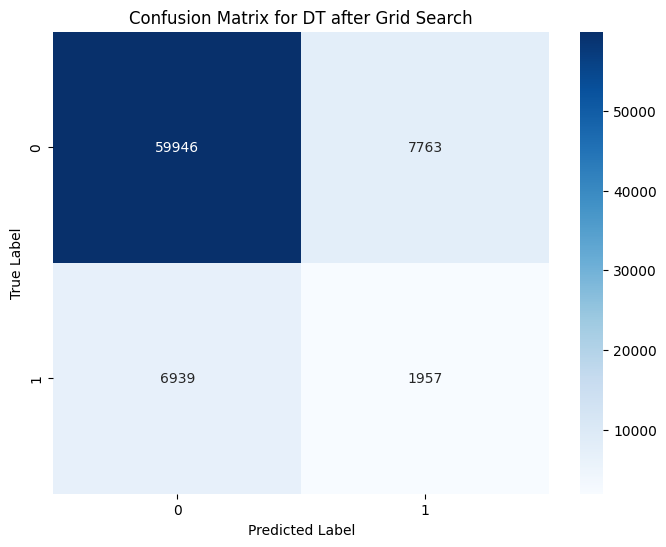
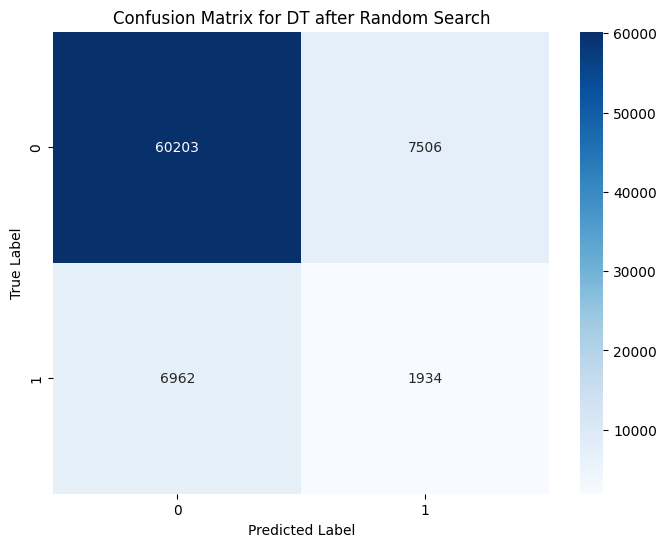
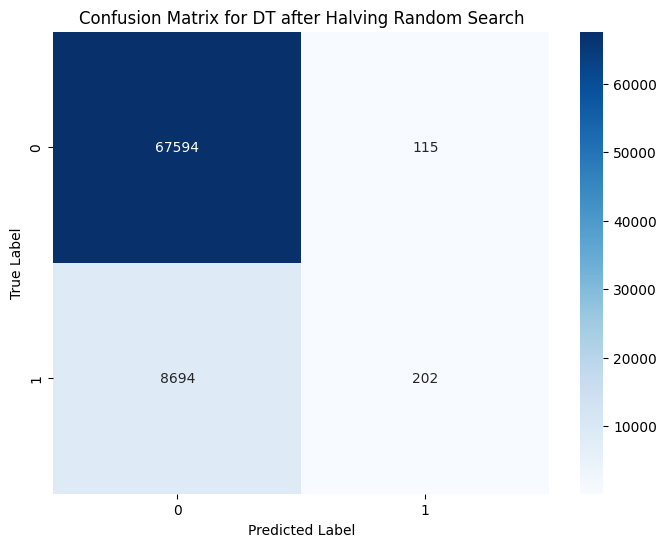

<b>ROC-AUC Comparisons</b>
<pre>ROC AUC Score: 0.5526670506075461                          ROC AUC Score: 0.5610534032860258 </pre>

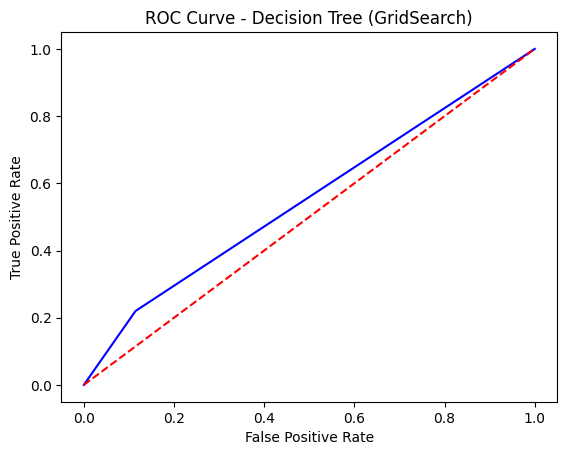
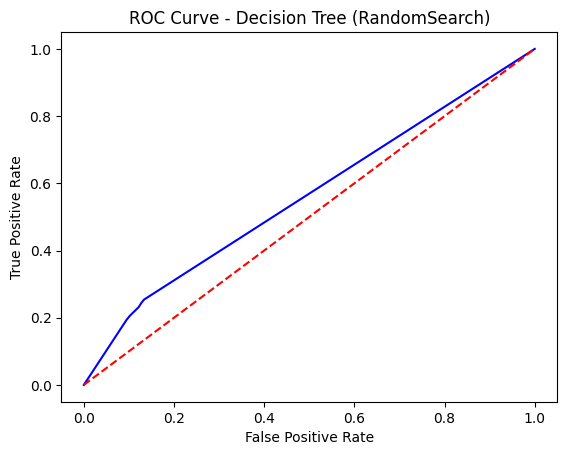

<pre>ROC AUC Score: 0.7206343350713394                          ROC AUC Score: 0.7072385488720191</pre>

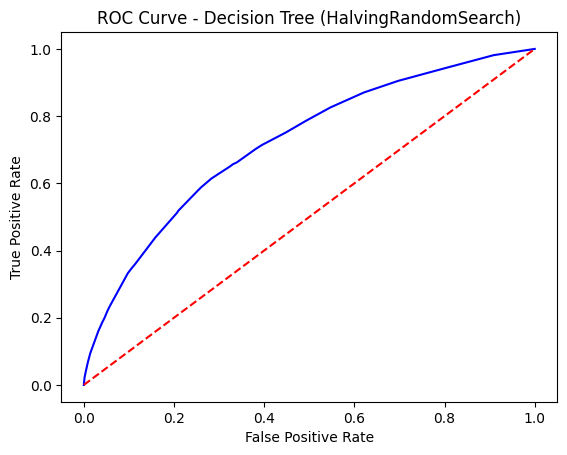
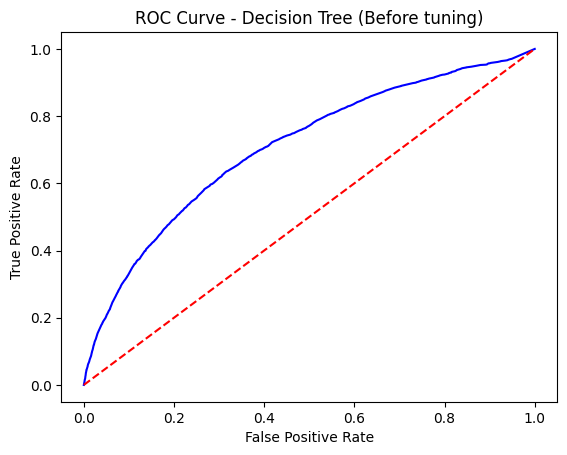


Although halving random search had the worst f1 score, it has the best ROC-AUC due to having the least number of false positives (115) compared to the number of true positives (202). The decision tree model before tuning had a comparable ratio (682 false positives vs. 570 true positives), thus their ROC-AUC scores are close.
The models tuned with grid search and random search had worse ROC-AUC scores in spite of the improvement in f1-scores because the increase in false positives (about +7000) dwarfed the increase in true positives (about +1400).

## KNN

### Before Hyperparameter tuning

In [52]:
# KNN with default settings before tuning
from sklearn.neighbors import KNeighborsClassifier

knn_base = KNeighborsClassifier()
knn_base.fit(X_train, y_train)
y_pred_base = knn_base.predict(X_test)
accuracy = knn_base.score(X_test, y_test)
# print(f'Accuracy: {accuracy:.2f}')
print("KNN Classification Report before tuning:\n", classification_report(y_test, y_pred_base))

KNN Classification Report before tuning:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93     67709
           1       0.12      0.01      0.02      8896

    accuracy                           0.87     76605
   macro avg       0.50      0.50      0.48     76605
weighted avg       0.80      0.87      0.83     76605



ROC AUC Score: 0.5067470315200968


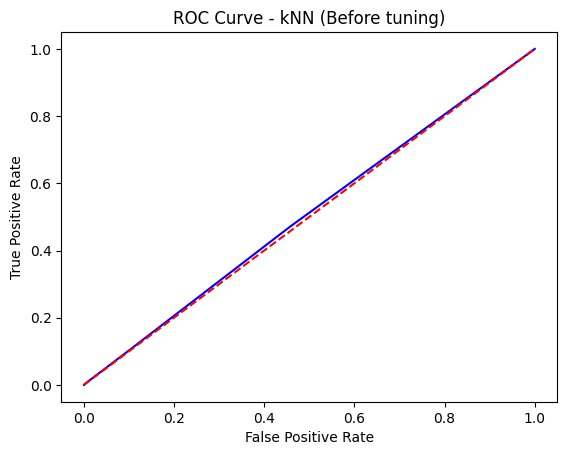

In [64]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_knn = knn_base.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - kNN (Before tuning)');

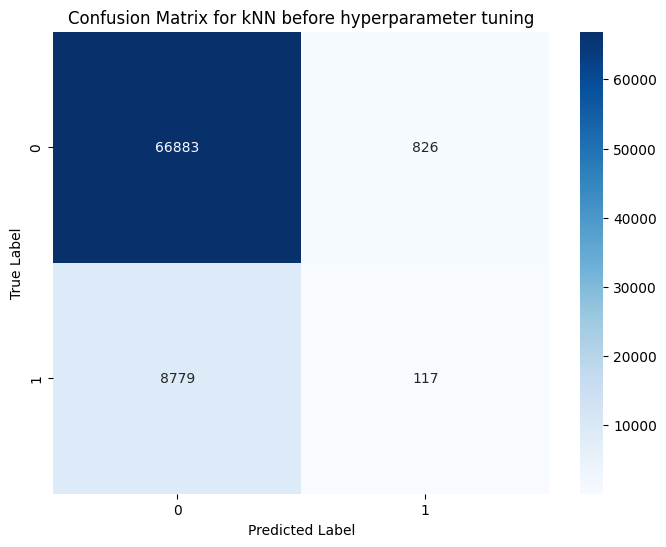

In [53]:
cm = confusion_matrix(y_test, y_pred_base)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for kNN before hyperparameter tuning')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### With Hyperparameter Tuning

#### Grid Search with Cross-Validation

In [54]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the KNN model
knn = KNeighborsClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Use f1 as the evaluation metric due to imbalanced dataset
    verbose=1,
    n_jobs=-1  # Use all available cores for computation
)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test data
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

# Print evaluation metrics
print("F1:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
F1: 0.06539976031501456
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     67709
           1       0.14      0.04      0.07      8896

    accuracy                           0.86     76605
   macro avg       0.51      0.50      0.49     76605
weighted avg       0.80      0.86      0.82     76605



ROC AUC Score: 0.5178116397871084


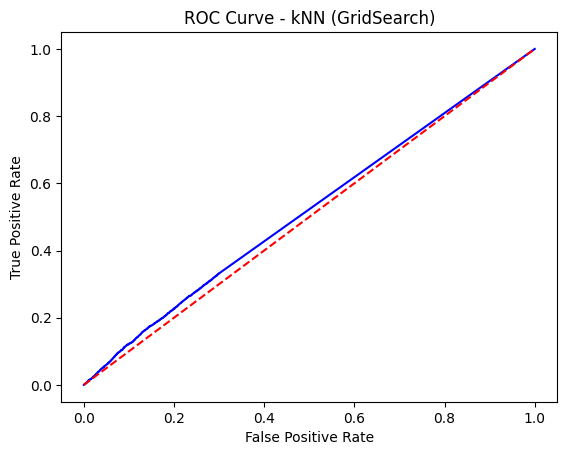

In [55]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_knn = best_knn.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - kNN (GridSearch)');

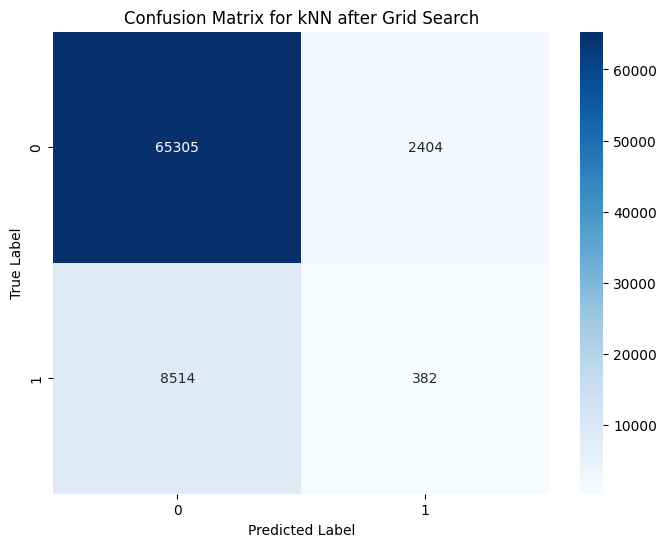

In [56]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for kNN after Grid Search')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Random Search with Cross-Validation

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Define the KNN model
knn = KNeighborsClassifier()

# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Cross-validation strategy
cv_knn = KFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV with 20 iterations
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to test
    scoring='f1',  # Use F1-score for imbalanced data
    cv=cv_knn,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the random search
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
print("Best cross-validation score using F1:", random_search.best_score_)

# Evaluate the best model on the test data
best_knn = random_search.best_estimator_
y_pred = best_knn.predict(X_test)

# Print evaluation metrics
print("F1:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

c:\Users\jenif\anaconda3\envs\new_env\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}
Best cross-validation score using F1: 0.06357576553820951
F1: 0.06539976031501456
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     67709
           1       0.14      0.04      0.07      8896

    accuracy                           0.86     76605
   macro avg       0.51      0.50      0.49     76605
weighted avg       0.80      0.86      0.82     76605



ROC AUC Score: 0.5178116397871084


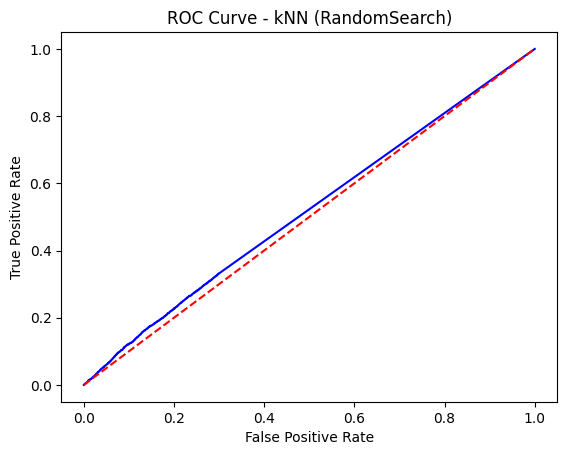

In [58]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_knn = best_knn.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - kNN (RandomSearch)');

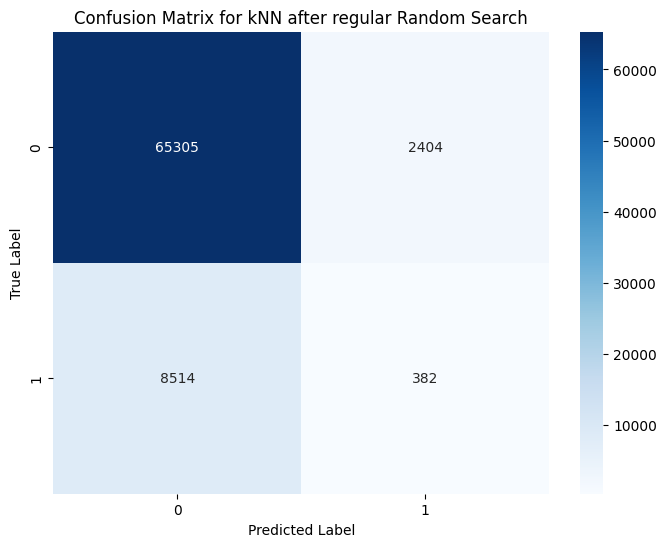

In [59]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for kNN after regular Random Search')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Halving Random Search with Cross-Validation

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Define the KNN model
knn = KNeighborsClassifier()

# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Cross-validation strategy
cv_knn = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

random_search = HalvingRandomSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    scoring='f1',
    cv=cv_knn,
    factor=2,  # Reduce configurations by a factor of 2 at each iteration
    random_state=42,
    n_jobs=-1
)

# Fit the random search
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
print("Best cross-validation score using F1:", random_search.best_score_)

# Evaluate the best model on the test data
best_knn = random_search.best_estimator_
y_pred = best_knn.predict(X_test)

# Print evaluation metrics
print("F1:", f1_score(y_test, y_pred))
print("Classification Report for knn after tuning:\n", classification_report(y_test, y_pred))

c:\Users\jenif\anaconda3\envs\new_env\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 30 is smaller than n_iter=8937. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}
Best cross-validation score using F1: 0.0
F1: 0.05977840762690028
Classification Report for knn after tuning:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     67709
           1       0.13      0.04      0.06      8896

    accuracy                           0.86     76605
   macro avg       0.51      0.50      0.49     76605
weighted avg       0.80      0.86      0.82     76605



ROC AUC Score: 0.5104979375875454


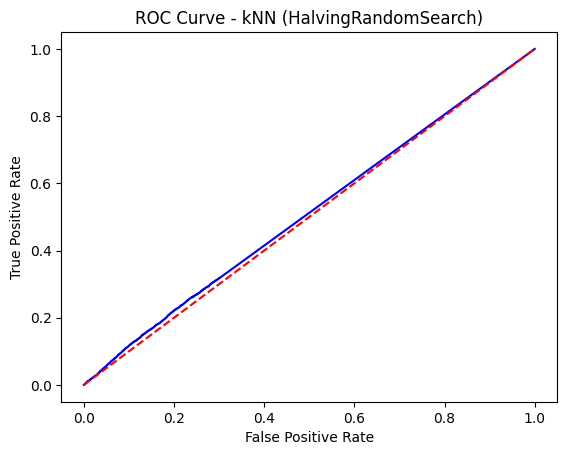

In [61]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_knn = best_knn.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - kNN (HalvingRandomSearch)');

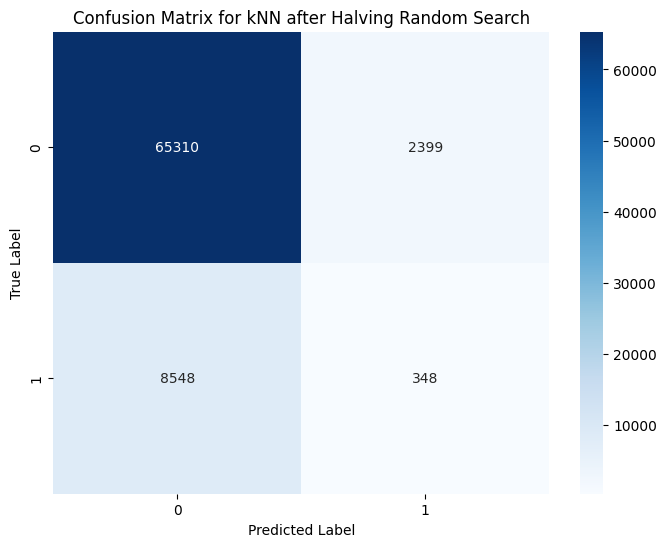

In [62]:
cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for kNN after Halving Random Search')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Comparison of Results for kNN

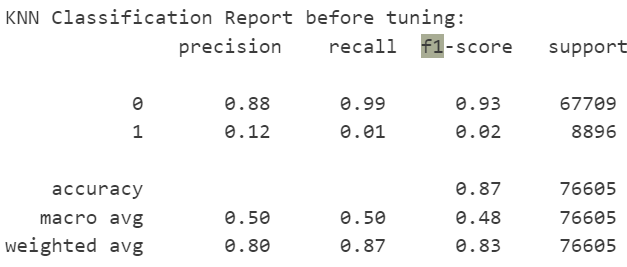

<br>
<b>Using halving random search</b>

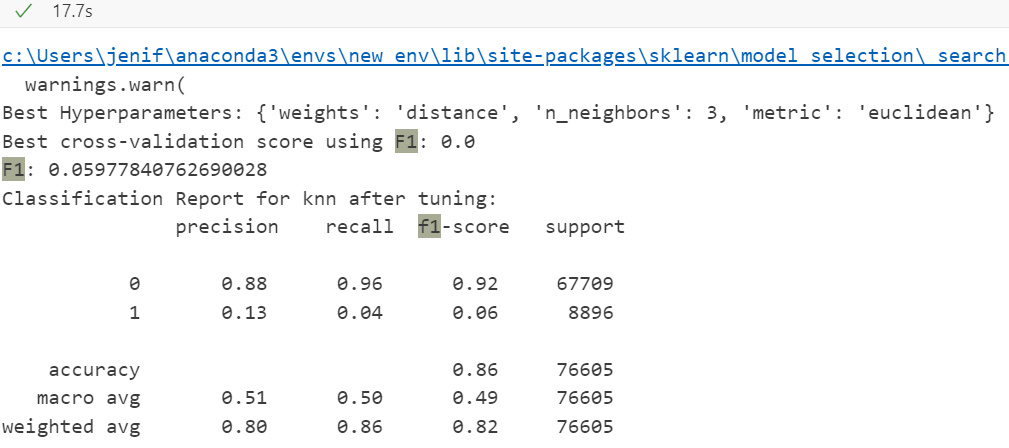

<br>
<b>Using regular random search</b>

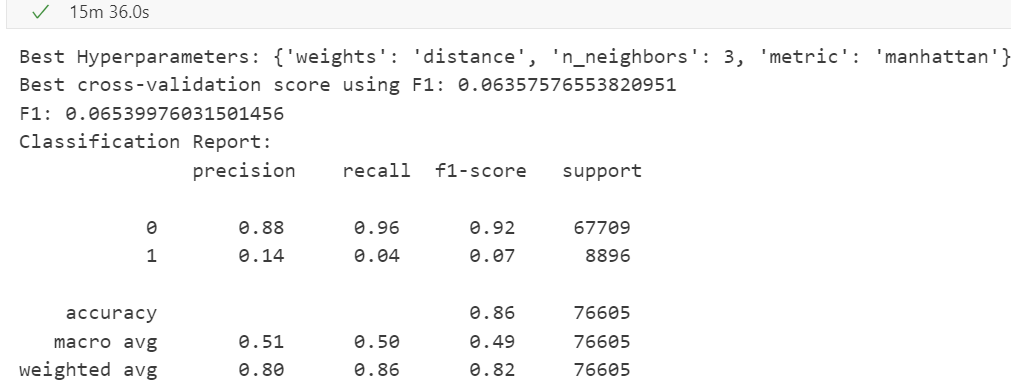

<br>
<b>Using grid search</b>

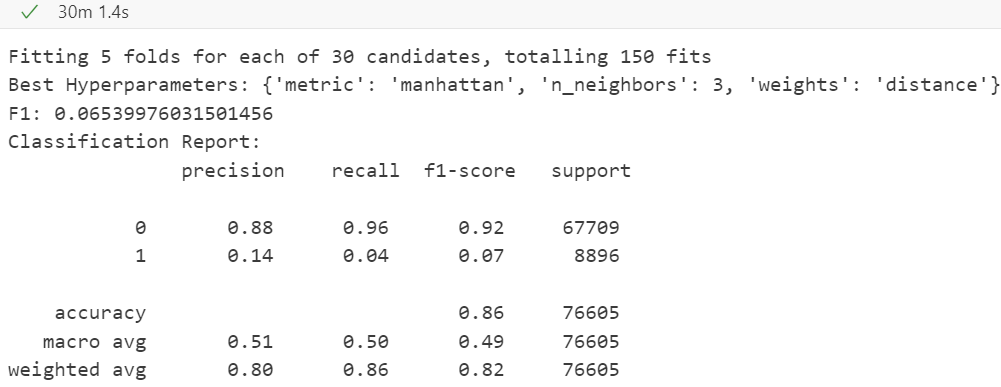

Both precision and recall for the minority class (Default = 1), had very slight improvements, yielding an overall improvement in the f1-score for all three strategies. Accuracy decreased slightly (-0.01) and recall for the negative class decreased due to the increase in misclassifications, decreasing f1 for the majority class.

#### Confusion matrices comparison for kNN
<br><br>
Since grid search and random search return the same result, 'after hyperparameter tuning' refers to either strategy.
<br>

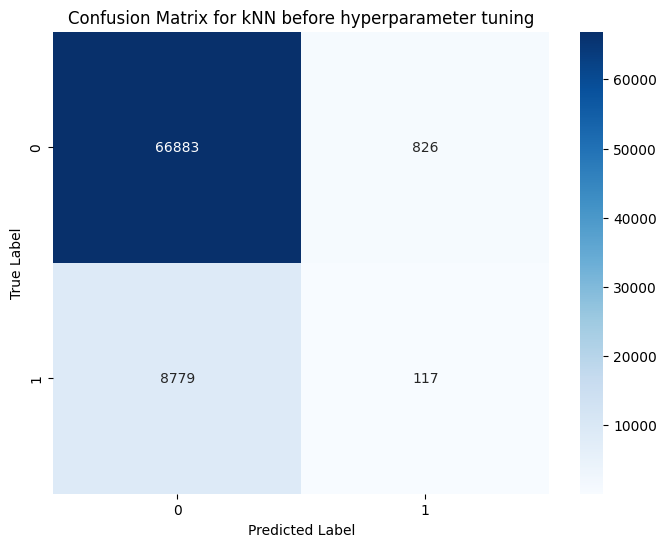
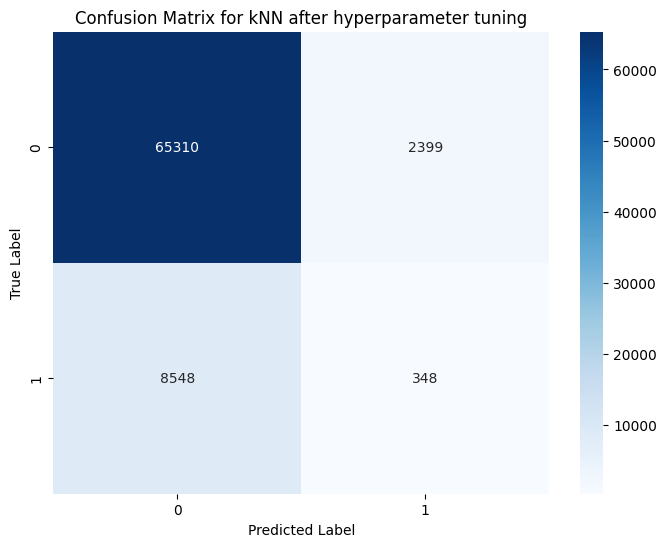
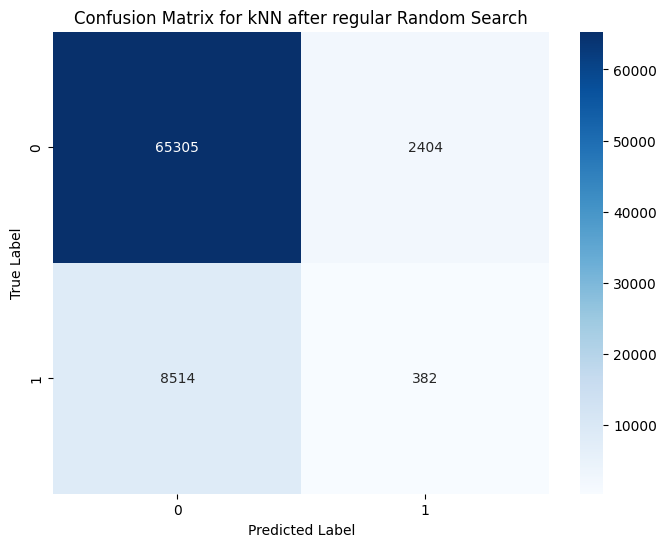
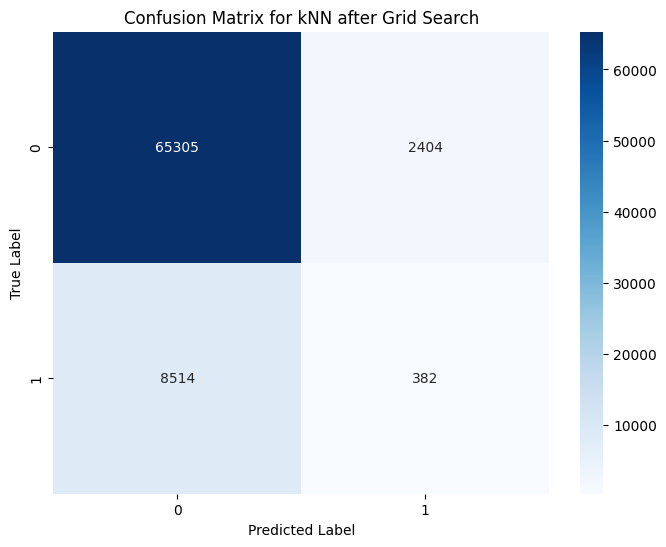
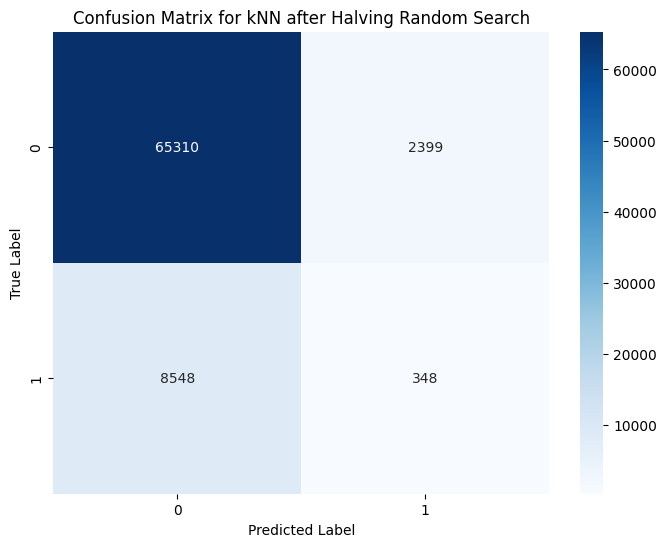

Halving random search returned slightly less false positives (-5), which was outweighted by having less true positives (-34).
<br><br>
<b>ROC-AUC comparison</b>
<pre>ROC AUC Score: 0.5178116397871084                          ROC AUC Score: 0.5178116397871084</pre>

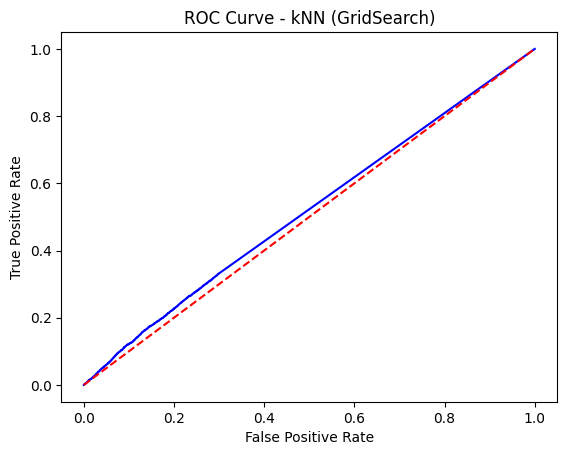
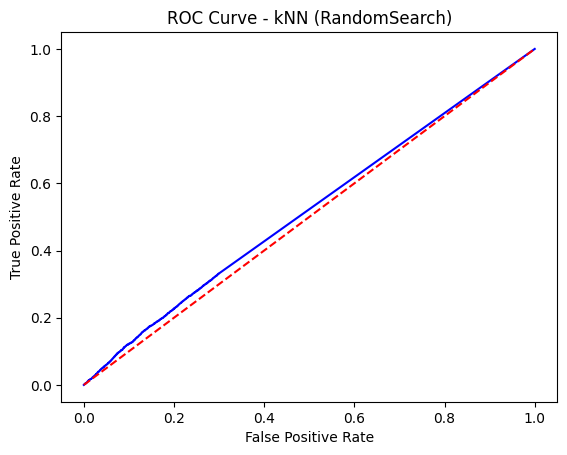

<pre>ROC AUC Score: 0.5104979375875454                          ROC AUC Score: 0.5067470315200968</pre>

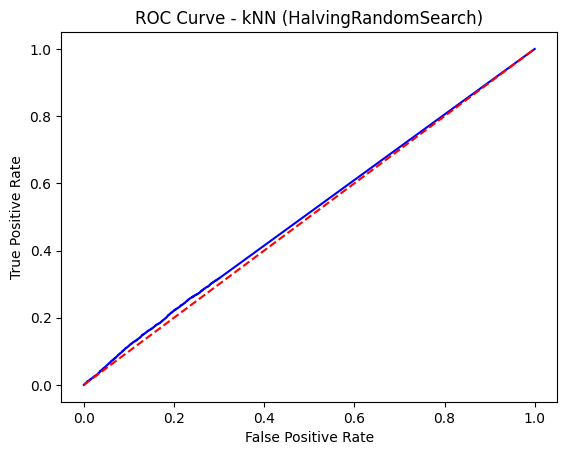
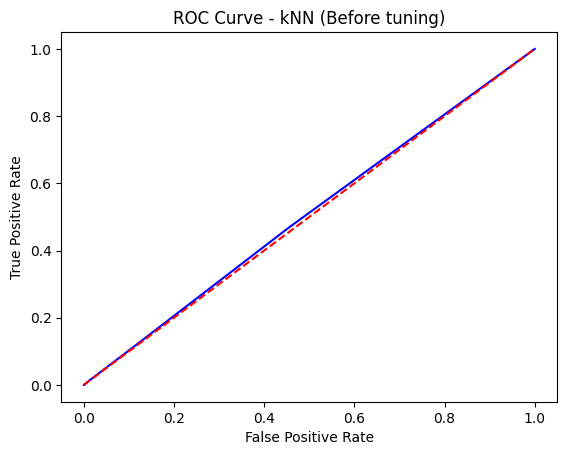
<br>
Though Halving Random Search was by far the fastest, the model tuned with it had the worst performance by about -0.007, but is still comparable to models tuned with the other two strategies. All of the tuned models did better than the model without hyperparameter tuning. Even so, kNN was the worst performing model, almost doing no better than random chance.

## Logistic Regression

### Before hyperparameter tuning

In [40]:
from sklearn.linear_model import LogisticRegression

# Load data
df = pd.read_csv('./preprocessed_data.csv')

# Train-test split
X = df.drop(['Default'], axis=1)
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42 
)

# Logistic Regression Model

#Train model
lr_model = LogisticRegression(max_iter=1000,random_state=42)
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     67709
           1       0.62      0.03      0.06      8896

    accuracy                           0.89     76605
   macro avg       0.76      0.51      0.50     76605
weighted avg       0.86      0.89      0.84     76605



ROC AUC Score: 0.7497218560867385


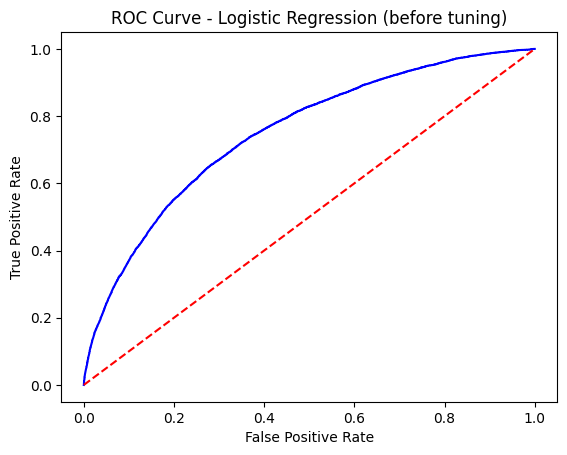

In [65]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (before tuning)');

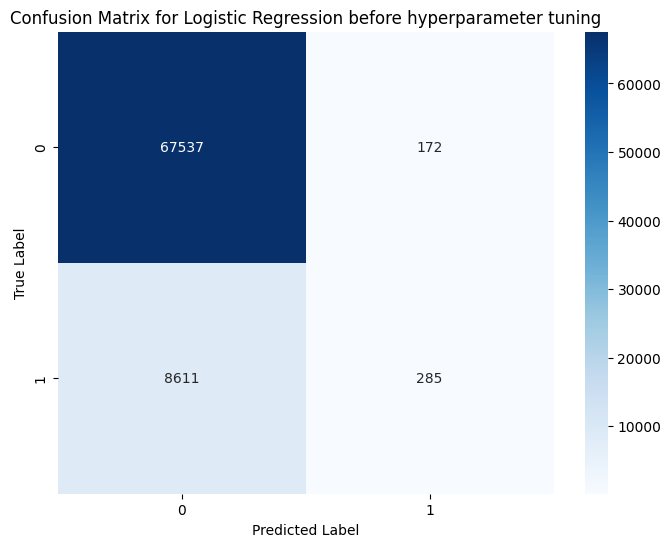

In [41]:
cm = confusion_matrix(y_test, y_pred_lr)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for Logistic Regression before hyperparameter tuning')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### With Hyperparameter Tuning

#### With Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Define the model
lr = LogisticRegression(random_state=42)

# Set the parameter distributions
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 20, 50, 100],
    'class_weight': ['balanced', None],
    'max_iter': [100, 200, 500, 1000]
}

# Define the cross-validation (cv) strategy
cv_lr = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with cross-validation
grid_search_lr = GridSearchCV(
    estimator=lr,
    param_grid=lr_param_grid,
    scoring='f1',  # Use F1 scoring to account for imbalanced dataset
    cv=cv_lr,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the random search
grid_search_lr.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search_lr.best_params_)
print('Best cross-validation score using F1:', grid_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr = grid_search_lr.best_estimator_
y_pred = best_lr.predict(X_test)

# Print evaluation metrics
print("F1:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best Hyperparameters: {'C': 50, 'class_weight': 'balanced', 'max_iter': 200}
Best cross-validation score using F1: 0.3269642223987014
F1: 0.33327068173885027
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.67      0.79     67709
           1       0.22      0.70      0.33      8896

    accuracy                           0.68     76605
   macro avg       0.58      0.69      0.56     76605
weighted avg       0.86      0.68      0.73     76605



c:\Users\jenif\anaconda3\envs\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score: 0.7496173468777887


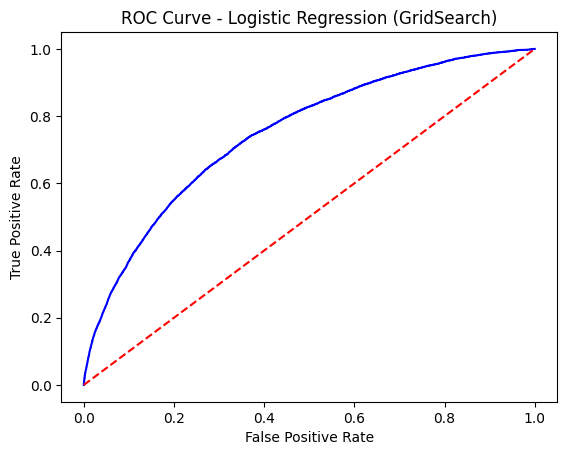

In [43]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_lr = best_lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (GridSearch)');

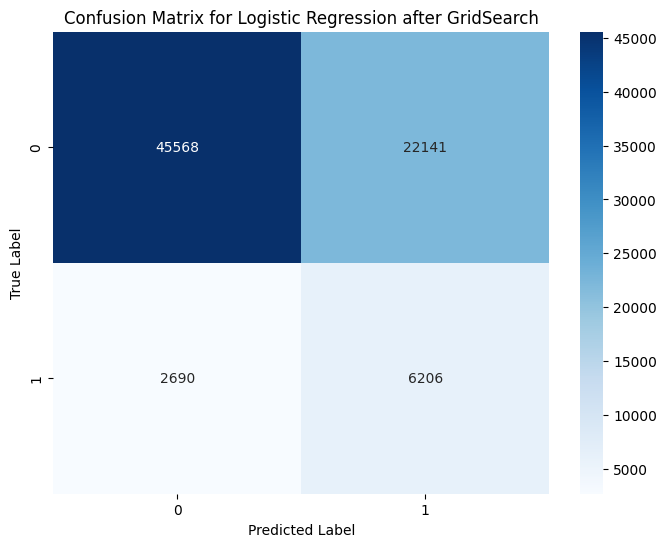

In [44]:
cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for Logistic Regression after GridSearch')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### With Random Search

In [45]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Define the model
lr = LogisticRegression(random_state=42)

# Set the parameter distributions
lr_param_dist = {
    'C': [0.01, 0.1, 1, 10, 20, 50, 100],
    'class_weight': ['balanced', None],
    'max_iter': [100, 200, 500, 1000]
}

# Define the cross-validation (cv) strategy
cv_lr = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform RandomizedSearchCV with cross-validation
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=lr_param_dist,
    n_iter=50,  # Number of parameter combinations to try
    scoring='f1',  # Use F1 scoring to account for imbalanced dataset
    cv=cv_lr,
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the random search
random_search_lr.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search_lr.best_params_)
print('Best cross-validation score using F1:', random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr = random_search_lr.best_estimator_
y_pred = best_lr.predict(X_test)

# Print evaluation metrics
print("F1:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'max_iter': 200, 'class_weight': 'balanced', 'C': 50}
Best cross-validation score using F1: 0.3269642223987014
F1: 0.33327068173885027
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.67      0.79     67709
           1       0.22      0.70      0.33      8896

    accuracy                           0.68     76605
   macro avg       0.58      0.69      0.56     76605
weighted avg       0.86      0.68      0.73     76605



c:\Users\jenif\anaconda3\envs\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score: 0.7496173468777887


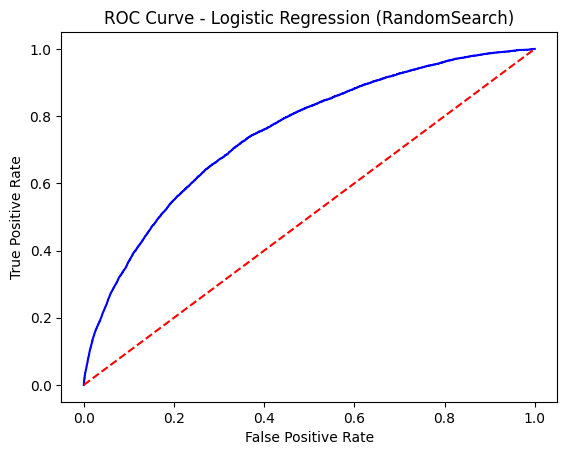

In [46]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_lr = best_lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (RandomSearch)');

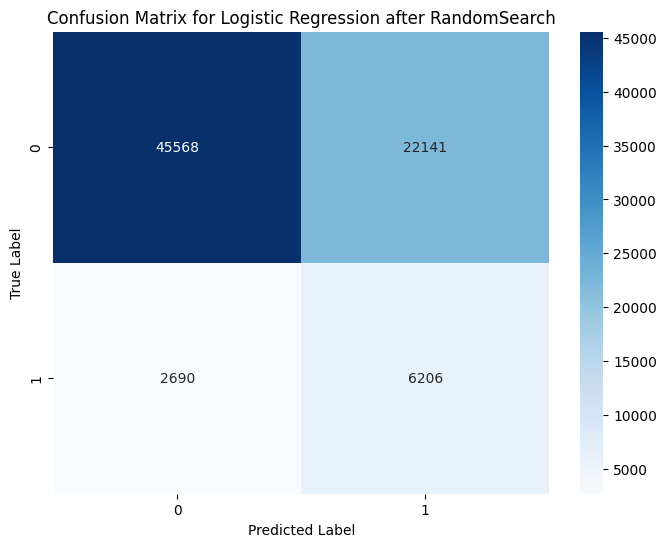

In [47]:
cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for Logistic Regression after RandomSearch')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### With Halving Random Search

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Define the lr model
lr = LogisticRegression(random_state=42)

# Set the parameter distributions
lr_param_dist = {
    'C': [0.01, 0.1, 1, 10, 20, 50, 100],
    'class_weight': ['balanced', None],
    'max_iter': [100, 200, 500, 1000]
}

# Cross-validation strategy
cv_lr = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

random_search = HalvingRandomSearchCV(
    estimator=lr,
    param_distributions=lr_param_dist,
    scoring='f1',
    cv=cv_lr,
    factor=2,  # Reduce configurations by a factor of 2 at each iteration
    random_state=42,
    n_jobs=-1,
)

# Fit the random search
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
print("Best cross-validation score using F1:", random_search.best_score_)

# Evaluate the best model on the test data
best_lr = random_search.best_estimator_
y_pred = best_lr.predict(X_test)

# Print evaluation metrics
print("F1:", f1_score(y_test, y_pred))
print("Classification Report for Logistic Regression after tuning:\n", classification_report(y_test, y_pred))

c:\Users\jenif\anaconda3\envs\new_env\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 56 is smaller than n_iter=8937. Running 56 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'max_iter': 500, 'class_weight': 'balanced', 'C': 10}
Best cross-validation score using F1: 0.3106110426568092
F1: 0.33317222490736265
Classification Report for Logistic Regression after tuning:
               precision    recall  f1-score   support

           0       0.94      0.67      0.79     67709
           1       0.22      0.70      0.33      8896

    accuracy                           0.68     76605
   macro avg       0.58      0.69      0.56     76605
weighted avg       0.86      0.68      0.73     76605



ROC AUC Score: 0.7496162577905596


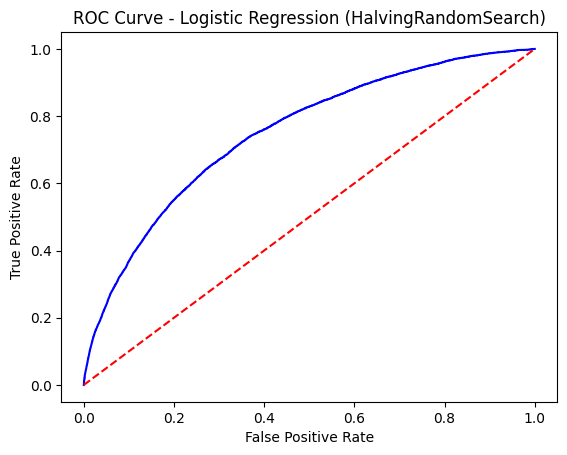

In [67]:
# ROC-AUC
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
y_pred_prob_lr = best_lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (HalvingRandomSearch)');

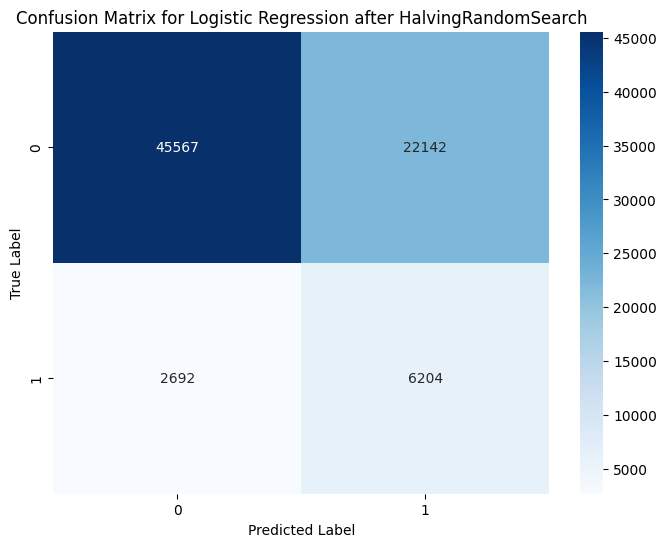

In [68]:
cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for Logistic Regression after HalvingRandomSearch')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Comparisons for Logistic Regression

<b>Without hyperparameter tuning</b>
<br>

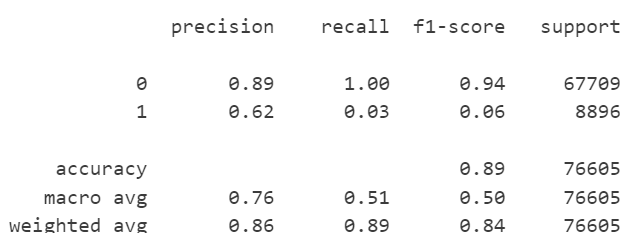

<b>Using grid search</b>
<br>

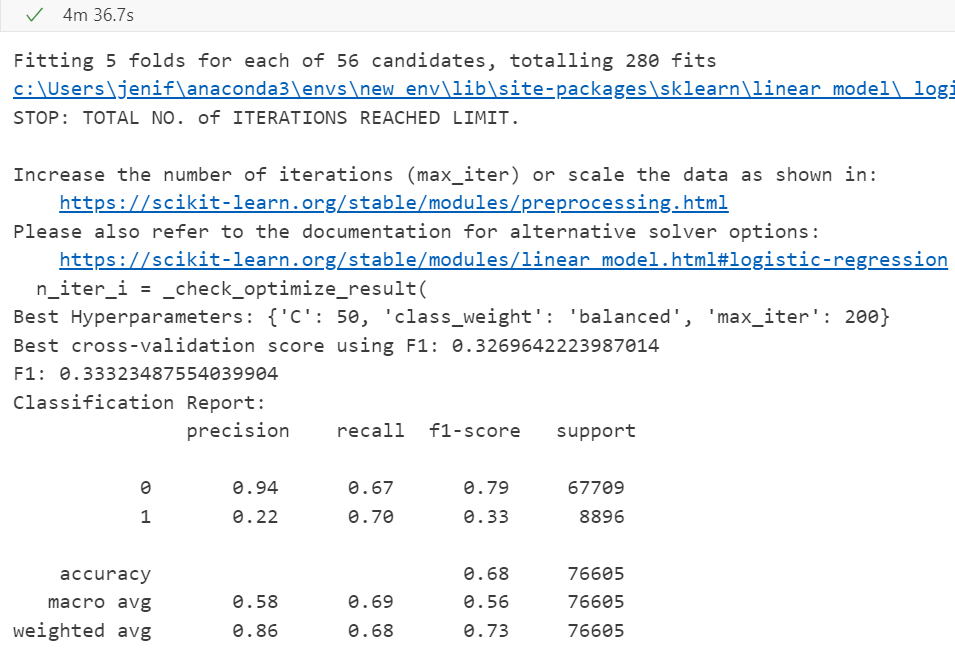

So far, tuning the hyperparameters increases the recall (+0.67 change) for the positive, minority class (Default=1), but at the cost of precision (-0.4) due to the greater presence of false positives. However, the f1-score increased significantly (+0.27) for the minority class. This also comes at the cost of accuracy (-0.21) and majority class f1-score (-0.15).
<br><br>
<b>Using random search</b>

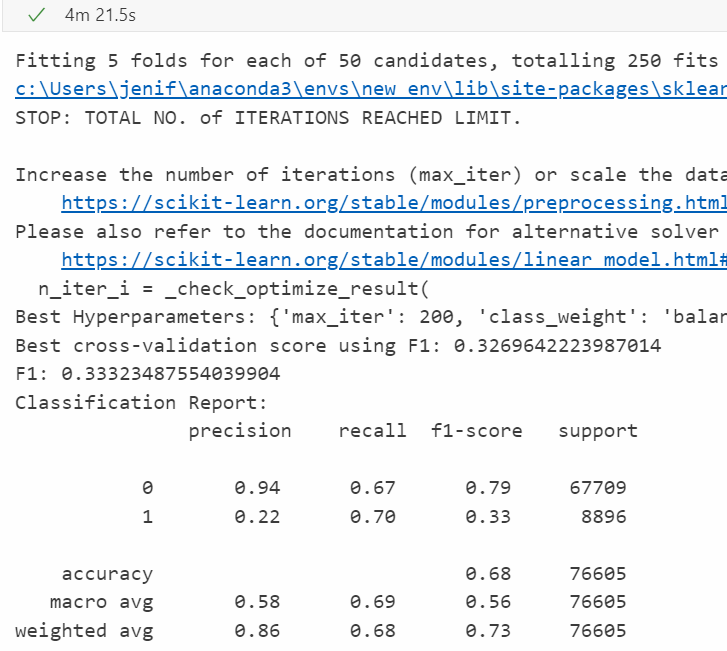
<br>
The processing time with grid search and random search are comparable. Sometimes grid search takes slightly longer. Other times, random search took slightly longer.
<br><br>
<b>Using halving random search</b>

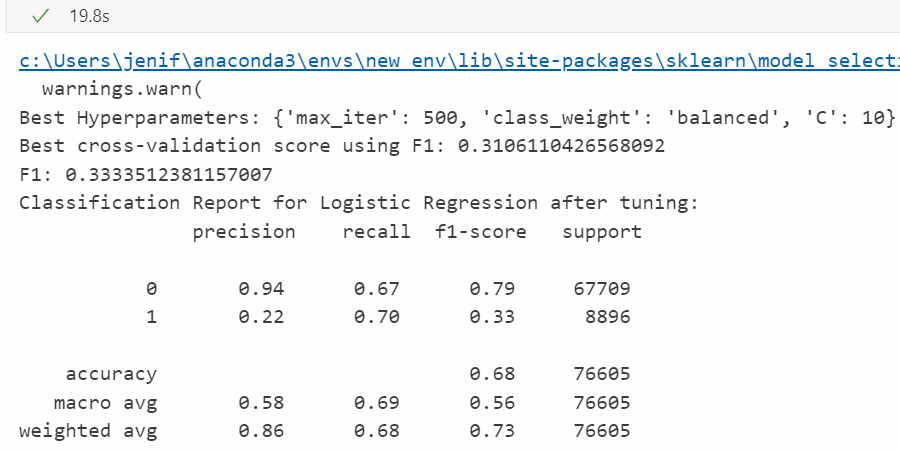
<br>
Halving random search was significantly faster than the other two tuning and cross-validation methods consistently. Despite the differences in processing time, the classification reports are all identical.

#### Confusion Matrices Comparison

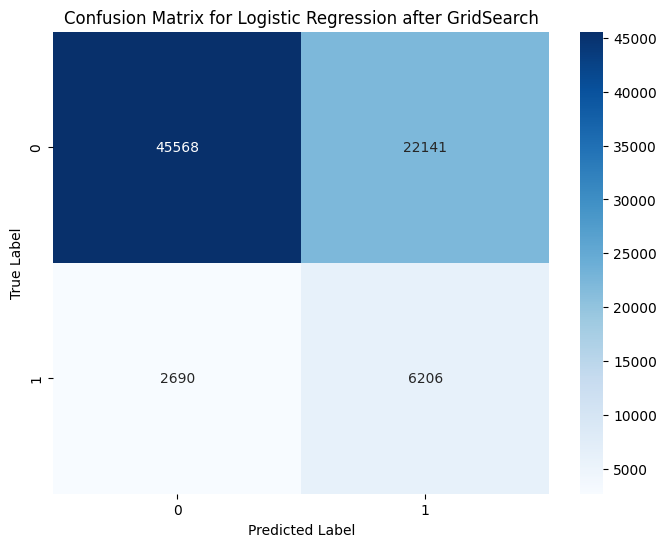
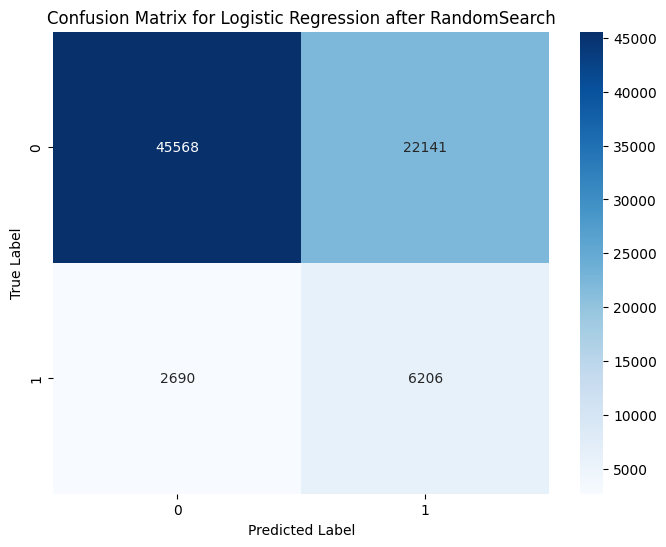

The two confusion matrices above are identical. The matrix below has very slightly fewer true positives (-2) and very slightly more false positives (+1).
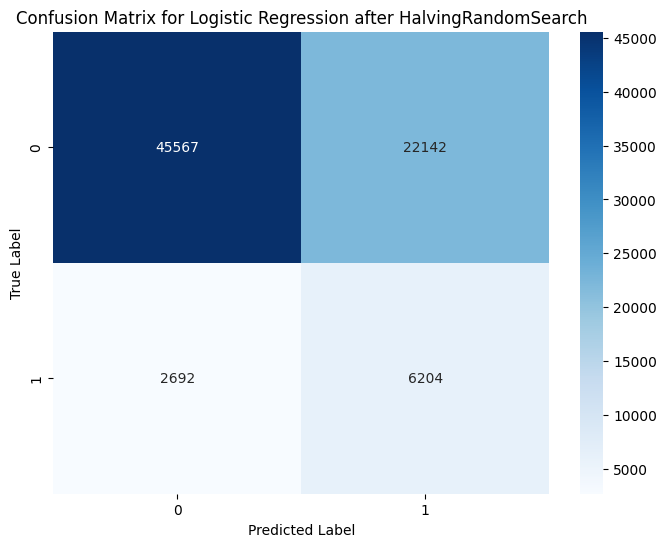
<br>
<b>ROC-AUC Comparison</b>
<pre>ROC AUC Score: 0.7496173468777887                          ROC AUC Score: 0.7496173468777887</pre>

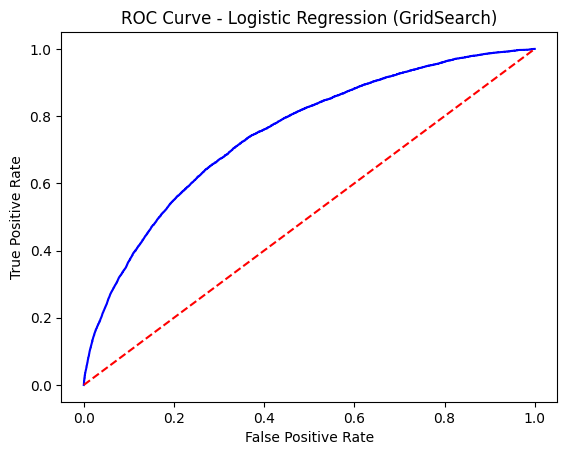
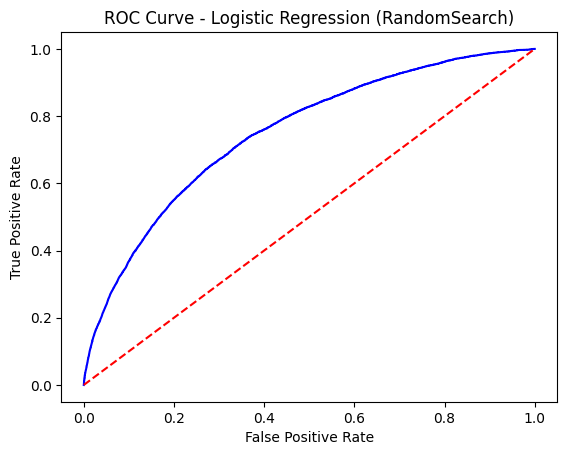

The two ROC-AUC scores above are identical.

<pre>ROC AUC Score: 0.7496162577905596                          ROC AUC Score: 0.7497218560867385</pre>

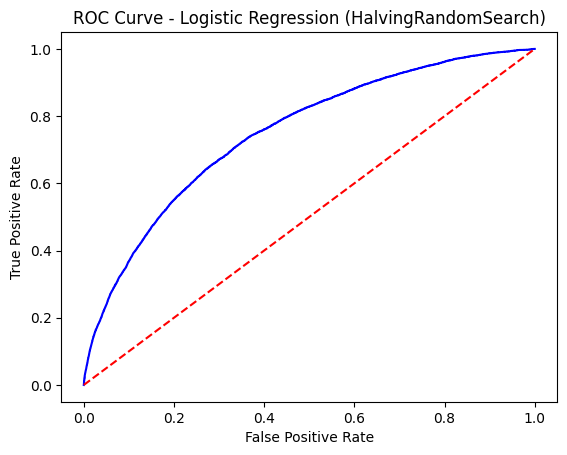
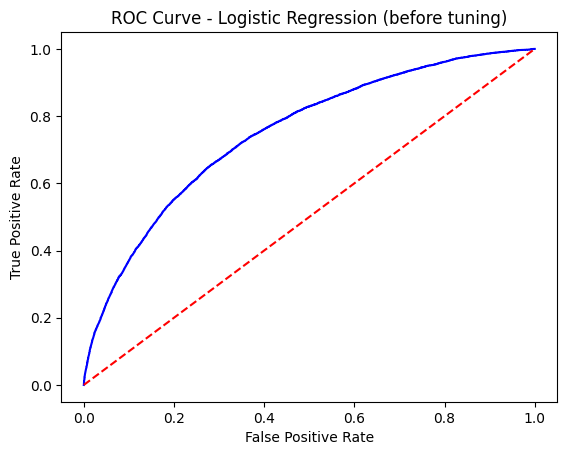

The ROC-AUC scores from tuning with halving random search is slightly lower than the other two by about -0.000001.  The baseline logistic regression ROC-AUC was the highest by about +0.0001.
In general, with tuning, the increase in the number of false positives outweigh the increase in the number of true positives, but not by a significant amount. Therefore, we believe that this is still acceptable considering that the cost of bad loans go beyond the immediate financial effects on the lending institution, but can lead to more costs, such as the loss of trust in the financial institution and spillover into greater society as recessions, such as what happened in 2008 as a result of the subprime mortgage crisis, where bad loans were purposely made and sold off as investment instruments. The loss of revenue from mistakingly denying trustworthy customers loans is a tolerable risk compared to the risk of losing money from loans going into default. 